In [1]:
# Recurrent Neural Network

#https://www.youtube.com/watch?v=zwqwlR48ztQ

# Recurrent Neural Network

# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the training set
dataset_train = pd.read_csv('./marketdata/zsh20.csv')
#dataset_train = dataset_train[dataset_train["Volume"] != 0]

dataset_train.Time = pd.to_datetime(dataset_train.Time.str.replace('D', 'T'))
dataset_train = dataset_train.sort_values('Time')
dataset_train.set_index('Time', inplace=True)
print(dataset_train.shape)
ax = dataset_train["Last"].plot(figsize=(14, 7))
ax.axvline("26-04-2019", linestyle="--", c="black")
ax.axvline("08-09-2019", linestyle="--", c="black")

(490, 7)


In [2]:
df_train = dataset_train[dataset_train.index < "26-04-2019"]
df_train.shape

(362, 7)

In [3]:
df_val = dataset_train[(dataset_train.index >= "26-04-2019") & (dataset_train.index < "08-09-2019")]
df_val.shape

(73, 7)

In [4]:
training_set = dataset_train.iloc[:, 1:7].values

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (-1, 1))
training_set_scaled = sc.fit_transform(training_set)

In [5]:
# Creating a data structure with 15 timesteps and 1 output - we use last 15 prices to predict next. 
#This takes data from 15th row onwards
X_whole = []
y_whole = []

X_whole_vchange = []
y_whole_vchange = []


X_whole_wvap = []
y_whole_wvap = []

sequence_size = 1
for i in range(sequence_size, len(training_set_scaled)):
    X_whole = np.append(X_whole, training_set_scaled[i-sequence_size:i, 2])
    #X_whole = np.append(X_whole, training_set_scaled[i, 6])
    #X_whole = np.append(X_whole, training_set_scaled[i, 7])
    vwap = 0
    vol = 0
    vchg = 0
    for j in range(sequence_size):
        if (j+i<training_set_scaled.shape[0]):
            vwap += (((np.sum(training_set_scaled[j+i, 0:3]))/3) * training_set_scaled[j+i, 4])
            vchg += (((training_set_scaled[j+i, 3])) * training_set_scaled[j+i, 4])
            vol += training_set_scaled[j+i, 4]
    #if vwap !=0  and vol != 0:
    X_whole = np.append(X_whole, vwap/vol)
    X_whole = np.append(X_whole, vchg/vol)
    y_whole.append(training_set_scaled[i, 2])

sz = training_set_scaled.shape[0]-sequence_size
X_whole, y_whole = np.array(X_whole.reshape(sz,sequence_size+2)), np.array(y_whole)

for i in range(sequence_size, len(X_whole)):
    X_whole_wvap = np.append(X_whole_wvap,X_whole[i-sequence_size:i, sequence_size])
    X_whole_wvap = np.append(X_whole_wvap,X_whole[i, 0])
    X_whole_wvap = np.append(X_whole_wvap,X_whole[i, sequence_size+1])
    y_whole_wvap.append(X_whole[i, sequence_size])
    
    X_whole_vchange = np.append(X_whole_vchange,X_whole[i-sequence_size:i, sequence_size+1])
    X_whole_vchange = np.append(X_whole_vchange,X_whole[i, 0])
    X_whole_vchange = np.append(X_whole_vchange,X_whole[i, sequence_size])
    y_whole_vchange.append(X_whole[i, sequence_size+1])

sz1 = X_whole.shape[0]-sequence_size
X_whole_wvap, y_whole_wvap = np.array(X_whole_wvap.reshape(sz1,sequence_size+2)), np.array(y_whole_wvap)
X_whole_vchange, y_whole_vchange = np.array(X_whole_vchange.reshape(sz1,sequence_size+2)), np.array(y_whole_vchange)

In [6]:
#Train -valid and Test split in time order
X_train = X_whole[0:362,:].copy()
X_valid = X_whole[362:420,:].copy()
X_test = X_whole[420:,:].copy()

y_train = y_whole[0:362].copy()
y_valid = y_whole[362:420].copy()
y_test = y_whole[420:].copy()

In [7]:
%%time
# Part 2 - Building the RNN

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
#X_whole = np.reshape(X_whole, (X_whole.shape[0], X_whole.shape[1], 1))

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#regressor.add(LSTM(units = 50, return_sequences = True))
#regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adm = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# Compiling the RNN
regressor.compile(optimizer = adm, loss = 'mean_squared_error' , metrics=["mean_squared_error"])

# Fitting the RNN to the Training set #, validation_data=(X_valid, y_valid)
hist = regressor.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs = 400, batch_size = 8, verbose=0)

Using TensorFlow backend.


Wall time: 1min 42s


dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


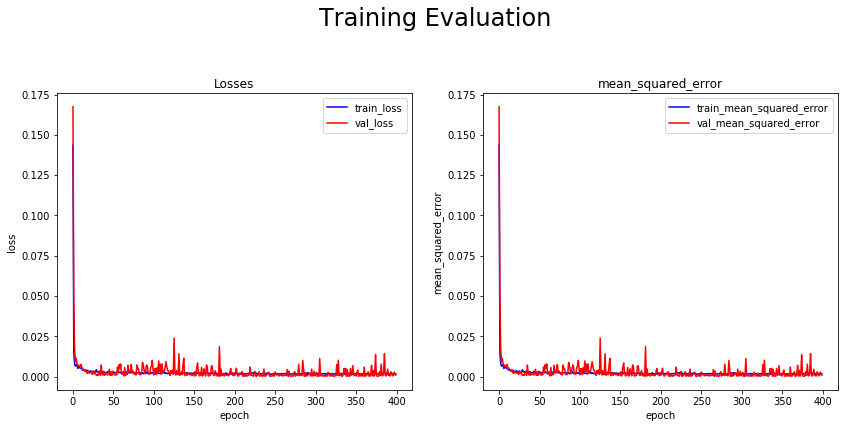

In [8]:
#regressor.save_weights("zns20_400epoch_Rsqr98.h5")
#print("Saved model to disk")
# load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")

plt.figure(figsize=(14,12))
plt.suptitle('Training Evaluation', fontsize=24)

plt.subplot(2,2,1)
#Plotting Training history
print(hist.history.keys())

# Visualising the results
plt.plot(hist.history['loss'], color = 'blue',  label = 'train_loss')
plt.plot(hist.history['val_loss'], color = 'red',  label = 'val_loss')
plt.title('Losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
#plt.show()
plt.subplot(2,2,2)
# Visualising the results
plt.plot(hist.history['mean_squared_error'], color = 'blue',  label = 'train_mean_squared_error')
plt.plot(hist.history['val_mean_squared_error'], color = 'red',  label = 'val_mean_squared_error')
plt.title('mean_squared_error')
plt.xlabel('epoch')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

In [9]:
#create empty table with 6 fields to inverse
test_data = np.zeros(shape=(len(y_test), 6) )
test_data[:,2] = y_test
real_stock_price = sc.inverse_transform(test_data)[:,2]
real_stock_price.shape[0]

69

In [10]:
from keras.models import model_from_json
def load_model(model_name):
    # load json and create model
    json_file = open(model_name+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_name+".h5")
    print("Loaded model from disk")
    return loaded_model



soy_close = regressor
soy_vwap = load_model("zsh20_1000epoch_Rsqr99_vwap_oct25")
soy_vchange = load_model("./models25oct/zsh20_1500epoch_Rsqr91_vchange")

#soy_close = load_model("zsk20_1000epoch_Rsqr99")
#soy_vwap = load_model("zsk20_1000epoch_Rsqr99_vwap")
#soy_vchange = load_model("zsk20_1500epoch_Rsqr91_vchange")

#soy_close = load_model("zsn20_1000epoch_Rsqr99")
#soy_vwap = load_model("zsn20_1000epoch_Rsqr99_vwap")
#soy_vchange = load_model("zsn20_1500epoch_Rsqr91_vchange")



#predicting on new data
xw=X_whole[-1,:].copy()
xw=xw.reshape(1,-1)
xw=np.reshape(xw,(xw.shape[0], xw.shape[1], 1))

xwvap = X_whole_wvap[-1,:].copy()
xwvap=xwvap.reshape(1,-1)
xwvap=np.reshape(xwvap,(xwvap.shape[0], xwvap.shape[1], 1))

xvchange=X_whole_vchange[-1,:].copy()
xvchange=xvchange.reshape(1,-1)
xvchange=np.reshape(xvchange,(xvchange.shape[0], xvchange.shape[1], 1))

y_pred_w = []

num_of_pred = real_stock_price.shape[0]

for i in range(0,num_of_pred):
    
    y_pred1=soy_close.predict(xw)
    test_data = np.zeros(shape=(len(y_pred1), 6) )
    test_data[:,2] = y_pred1
    y_transformed  = sc.inverse_transform(test_data)[:,2]
    y_pred_w = np.append(y_pred_w,y_transformed)
    
    
    y_pred2=soy_vwap.predict(xwvap)
    
    
    y_pred3=soy_vchange.predict(xvchange)
    
#    print(xw)
#    print(xwvap)
#    print(xvchange)
#    print(y_pred1,y_pred2,y_pred3)
    
    for j in range(sequence_size):
        xw[:,j]=xw[:,j+1]
        xwvap[:,j]=xwvap[:,j+1]
        xvchange[:,j]=xvchange[:,j+1]
        
    xw[:,sequence_size-1]=y_pred1
    xw[:,sequence_size]=y_pred2
    xw[:,sequence_size+1]=y_pred3
    
    xwvap[:,sequence_size-1]=y_pred2
    xwvap[:,sequence_size]=y_pred1
    xwvap[:,sequence_size+1]=y_pred3
    
    xvchange[:,sequence_size-1]=y_pred3
    xvchange[:,sequence_size]=y_pred1
    xvchange[:,sequence_size+1]=y_pred2
    
#    print(xw)
#    print(xwvap)
#    print(xvchange)
    
print(y_pred_w)
predicted_stock_price = y_pred_w
predicted_stock_price.shape[0]

Loaded model from disk
Loaded model from disk
[947.2809349  942.15732505 944.21408559 944.98805453 946.58282604
 948.02656326 949.47220404 950.78115109 951.95295919 952.96745434
 953.82832095 954.5440565  955.12992084 955.6035539  955.9831491
 956.28569418 956.5261506  956.7171286  956.8689354  956.98983262
 957.08635644 957.16363277 957.2256733  957.27561618 957.31592809
 957.34853667 957.37497008 957.39643639 957.4138886  957.42809921
 957.43968187 957.44912994 957.4568453  957.46314802 957.46829801
 957.47250945 957.47595561 957.47877848 957.48108635 957.48297789
 957.48452529 957.48579113 957.48682835 957.48767786 957.48837575
 957.4889461  957.48941056 957.4897932  957.49010846 957.49036837
 957.49058014 957.49075341 957.49089299 957.4910061  957.49109755
 957.49117215 957.49123713 957.49128526 957.49132617 957.49135986
 957.49138874 957.4914128  957.49143206 957.4914489  957.49146093
 957.49147297 957.49148259 957.49148741 957.49148981]


69

sqrt mean_squared_error:  44.052038702134176
mean_squared_error:  1940.5821138143272
mean_absolute_error:  37.4485595115069


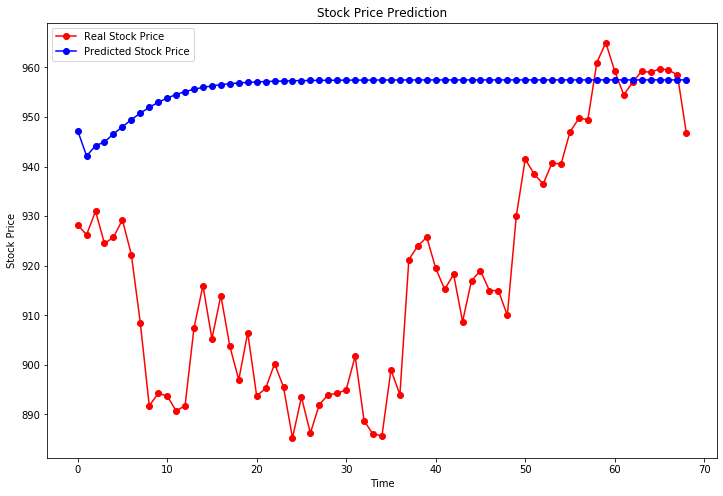

In [11]:
# Part 3 - Making the predictions and visualising the results
#real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#predicted_stock_price = regressor.predict(X_test)
# create empty table with 6 fields to inverse
#test_data = np.zeros(shape=(len(predicted_stock_price), 6) )
#test_data[:,2] = predicted_stock_price.reshape(1,-1)
#predicted_stock_price = sc.inverse_transform(test_data)[:,2]


#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))
print("mean_squared_error: ", mean_squared_error(real_stock_price, predicted_stock_price))
mean_absolute_error = mean_absolute_error(real_stock_price, predicted_stock_price)
print("mean_absolute_error: ", mean_absolute_error)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [12]:
#real_stock_price, predicted_stock_price
SS_Residual = sum((real_stock_price-predicted_stock_price)**2)
SS_Total = sum((real_stock_price-np.mean(real_stock_price))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(real_stock_price)-1)/(len(real_stock_price)-X_train.shape[1]-1)
print ("R Squared:", r_squared, "\nAdjusted R Squared:", adjusted_r_squared)

R Squared: -2.3843729658823167 
Adjusted R Squared: -2.540574795076885


In [13]:
'''import plotly.express as px

# Getting the real stock price 
# Importing the training set
dataset_train = pd.read_csv('./marketdata/zsh20.csv')
#dataset_train = dataset_train[dataset_train["Volume"] != 0]
training_set = dataset_train.iloc[:, 4:5].values
real_stock_price = dataset_train.iloc[422:, 4:5].values

prices = pd.DataFrame(real_stock_price, columns=["prices"])
prices["Time"] = dataset_train["Time"].iloc[422:].values
prices['data'] = 'real_stock_price'

prices1 = pd.DataFrame(predicted_stock_price, columns=["prices"])
prices1["Time"] = dataset_train["Time"].iloc[422:].values
prices1['data'] = 'predicted_stock_price'
prices1.fillna("10/26/2019", inplace=True)

prices = prices.append(prices1, ignore_index=True)

fig = px.line(prices, x="Time", y="prices", line_dash="data")
fig.show()'''

'import plotly.express as px\n\n# Getting the real stock price \n# Importing the training set\ndataset_train = pd.read_csv(\'./marketdata/zsh20.csv\')\n#dataset_train = dataset_train[dataset_train["Volume"] != 0]\ntraining_set = dataset_train.iloc[:, 4:5].values\nreal_stock_price = dataset_train.iloc[422:, 4:5].values\n\nprices = pd.DataFrame(real_stock_price, columns=["prices"])\nprices["Time"] = dataset_train["Time"].iloc[422:].values\nprices[\'data\'] = \'real_stock_price\'\n\nprices1 = pd.DataFrame(predicted_stock_price, columns=["prices"])\nprices1["Time"] = dataset_train["Time"].iloc[422:].values\nprices1[\'data\'] = \'predicted_stock_price\'\nprices1.fillna("10/26/2019", inplace=True)\n\nprices = prices.append(prices1, ignore_index=True)\n\nfig = px.line(prices, x="Time", y="prices", line_dash="data")\nfig.show()'